In [16]:
from typing import Callable, List, Any
from jax.experimental.host_callback import id_print
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import vmap, grad, jacrev, jacfwd, jit
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import random
import optax
from functools import partial
import flax
from tqdm.auto import tqdm

In [17]:
def jacsqzr(f, *args, **kwargs):
    return lambda *fargs, **fkwargs: jnp.squeeze(jacrev(f, *args, **kwargs)(*fargs, **fkwargs))


In [18]:
import h5py
from einops import rearrange

fps = ['./ground_truth/linadv_1p5_1D_1Q.hdf5']


data = []
for filepath in fps:
    with h5py.File(filepath, "r") as f:
        x = f['u'][()]
        data.append(x)

data = jnp.asarray(data)
data = data[:, :, ::2, ::20]
data = rearrange(data, 'm q t x -> (m t) x q')


T, N, Q = data.shape
print(data.shape)

(2001, 500, 1)


In [19]:
fp_test ='./ground_truth/linadv_2p0_1D_1Q.hdf5'

for filepath in fps:
    with h5py.File(fp_test, "r") as f:
        data_test = f['u'][()]
data_test = jnp.asarray(data_test)
data_test = data_test[0, :, ::20]
data_test = jnp.expand_dims(data_test, axis=-1)

In [20]:

def gen_noises(key, length, n_sigma, max_sigma):
    skey, nkey = jax.random.split(key)
    noise = jax.random.normal(nkey, shape=(n_sigma, length))
    sigma = jax.random.uniform(skey, shape=(n_sigma,), minval=0, maxval=max_sigma) 
    noise = noise * sigma[:, None]
    return noise

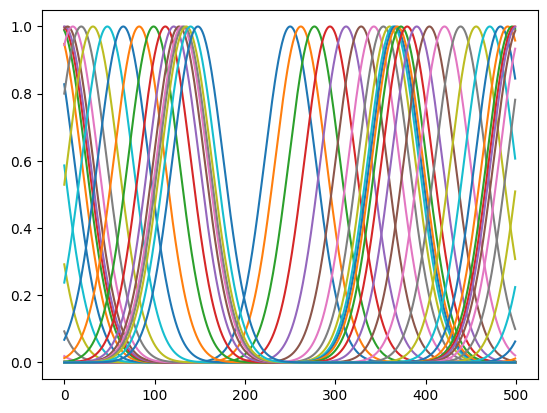

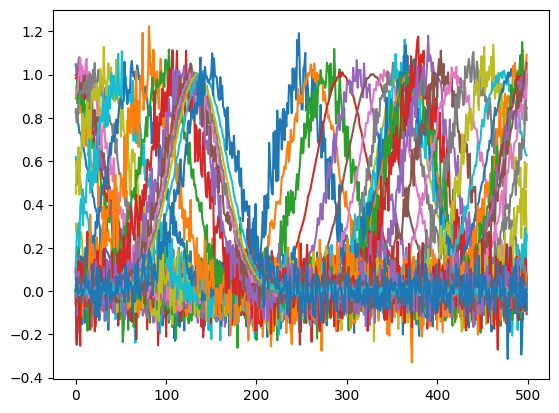

In [21]:
key = jax.random.PRNGKey(1)
max_sigma = 0.1
noise = gen_noises(key, data.shape[1], data.shape[0], max_sigma)
data_noise = data + noise[:,:,None]

key = jax.random.PRNGKey(2)
noise = gen_noises(key, data_test.shape[1], data_test.shape[0], max_sigma)
data_noise_test = data_test + noise[:,:,None]

plt.plot(jnp.squeeze(data[::50]).T)
plt.show()
plt.plot(jnp.squeeze(data_noise[::50]).T)
plt.show()

In [22]:
class Denoiser(nn.Module):
    features: int
    layers: int
    kernel_size: int = 3
    padding: str = 'CIRCULAR'

    @nn.compact
    def __call__(self, x):

        if x.shape[-1] != 1:
            x = jnp.expand_dims(x, axis=-1)
        A = nn.swish

        for l in range(self.layers-1):
            L = nn.Conv(features=self.features, kernel_size=(
                self.kernel_size,), padding=self.padding, use_bias=False)
            L = nn.WeightNorm(L)
            x = L(x)
            x = A(x)

        L = nn.Conv(features=1, kernel_size=(
            self.kernel_size,), padding=self.padding, use_bias=False)
        x = L(x)
        return x

In [23]:
DeNet = Denoiser(features=55, layers=8, kernel_size=15)
key, skey = jax.random.split(key)
theta_init = DeNet.init(key, data)
theta_init_flat, unravel = jax.flatten_util.ravel_pytree(theta_init)
F = DeNet.apply

In [24]:
from tqdm.auto import tqdm
iters = 2000
pbar = tqdm(range(iters))
lr = 1e-3


def loss_fn(params, y, key):
    tkey, nkey = jax.random.split(key)

    # add noise
    noise = gen_noises(nkey, y.shape[1], y.shape[0], max_sigma)
    x = y + noise[:, :, None]

    # denoise
    y_hat = F(params, x)

    # MSE
    loss = (y - y_hat)**2
    loss = loss.mean()  

    return loss


def update_step(optimizer, params, y, opt_state, key):

    total_loss, grads = jax.value_and_grad(
        loss_fn
    )(params, y, key)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return opt_state, params, total_loss


learning_rate = optax.cosine_decay_schedule(init_value=lr, decay_steps=iters)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(theta_init)
update_step = partial(update_step, optimizer)
update_step = jit(update_step)
params = theta_init
batch_size = 500
for i in pbar:
    nkey, skey, key = jax.random.split(key, 3)

    idx = jax.random.choice(skey, len(data), shape=(batch_size, ))
    y = data[idx]
    opt_state, params, total_loss = update_step(
        params, y, opt_state, nkey)
    pbar.set_postfix({'loss': f'{total_loss:.2E}'})

  0%|          | 0/2000 [00:00<?, ?it/s]

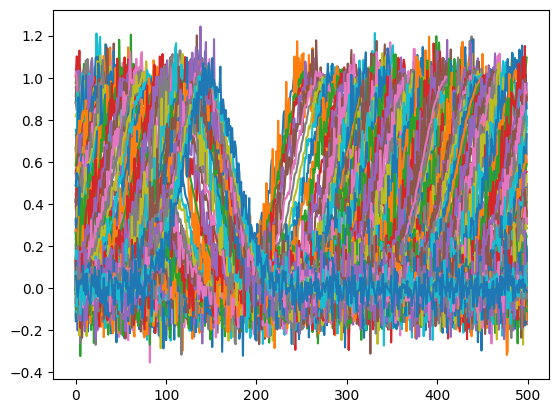

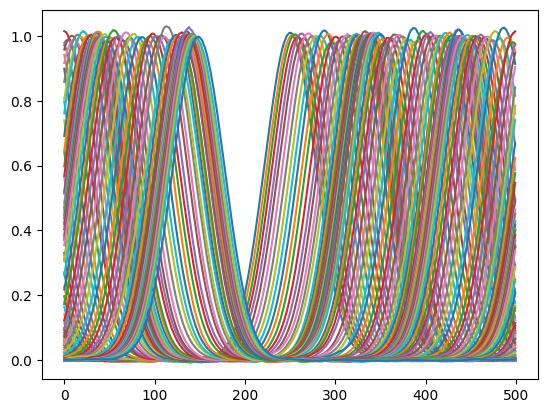

In [25]:
# plot noisey and denoised
y_hat = F(params, data_noise_test)
plt.plot(jnp.squeeze(data_noise_test[::25]).T)
plt.show()
plt.plot(jnp.squeeze(y_hat[::25]).T)
plt.show()

In [26]:
def normalize(a):
    return a/np.linalg.norm(a)

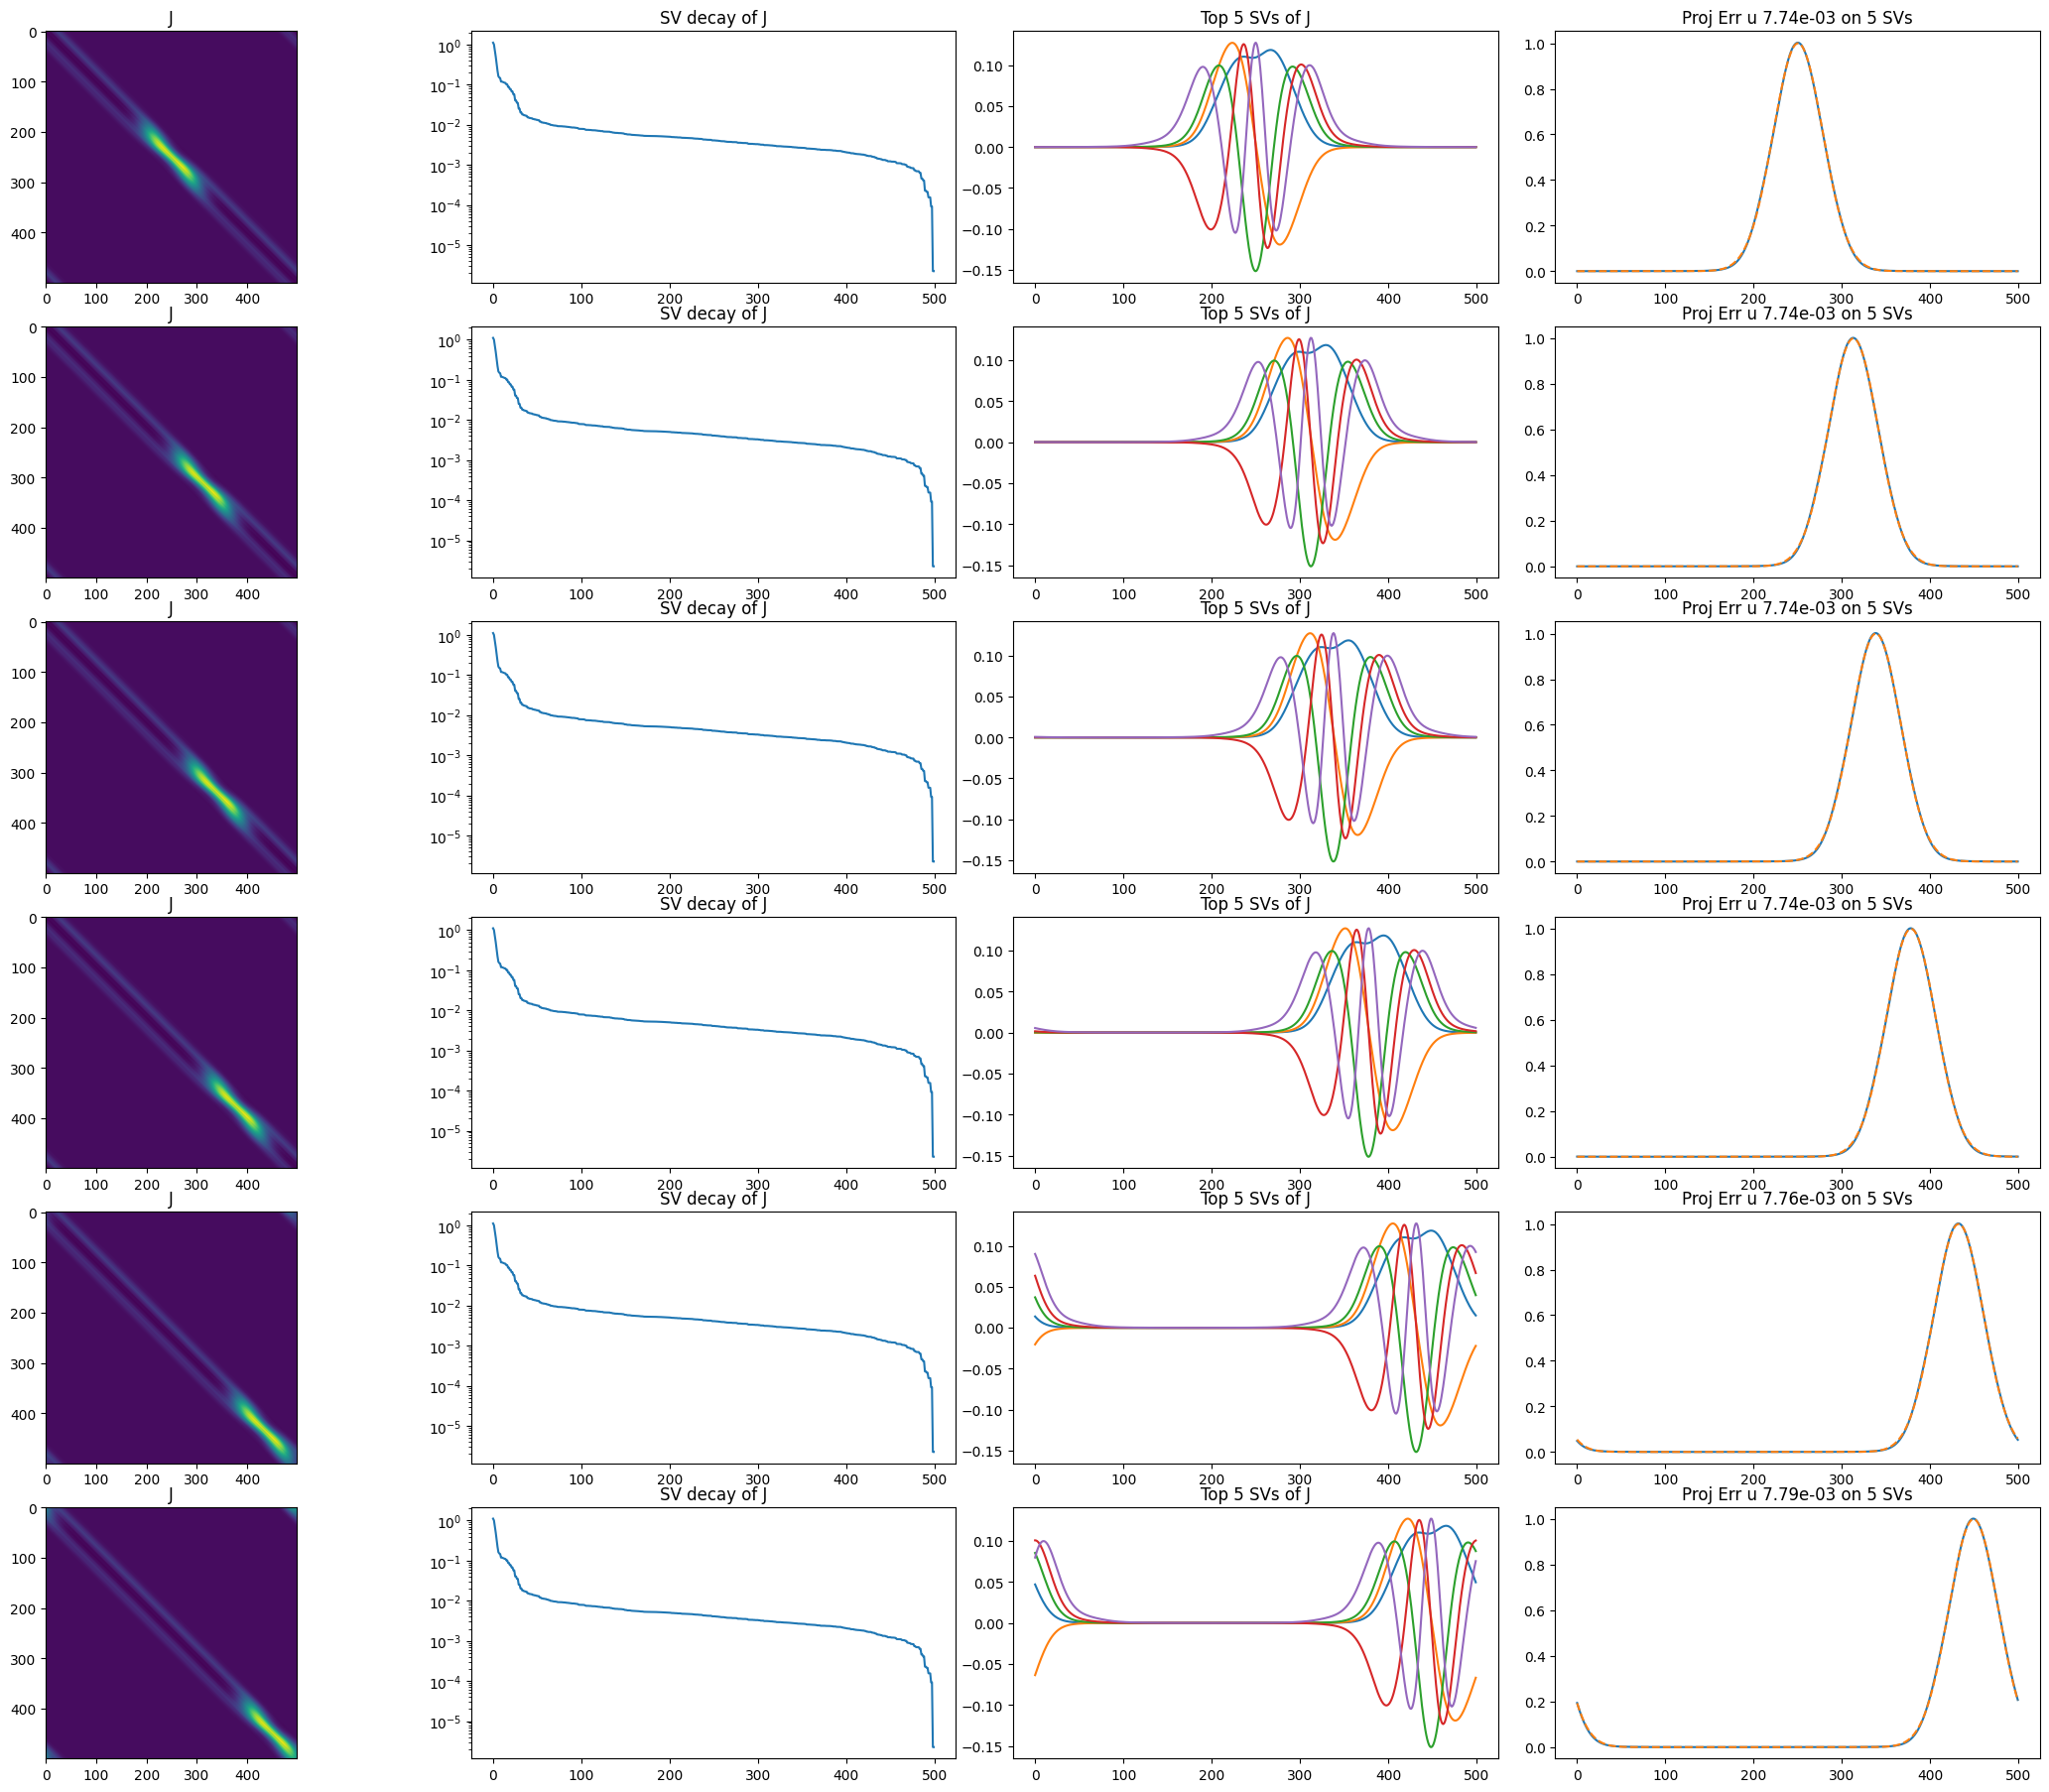

In [31]:
n_examples = 6 # number of examples to plot

examples_i = np.linspace(2, len(data)-1,n_examples, dtype=np.int32)
fig, axes = plt.subplots(n_examples, 4, figsize=(22,n_examples*3))
fig.tight_layout()
J_fn = jacsqzr(F, 1)

for ax_i,i in enumerate(examples_i):
    ax = axes[ax_i]
    u = np.squeeze(data_test[i])

    # plot jacobian
    J = J_fn(params, u)
    ax[0].imshow(J)
    ax[0].set_title(f'J')

    U, s, Vt = jnp.linalg.svd(J)
    # plto sv decay
    J = J_fn(params, u)
    ax[1].semilogy(s)
    ax[1].set_title(f'SV decay of J')

    # plot top svs
    n_svs = 5
    SVs = U[:, :n_svs]
    SVs *= np.sign(np.mean(SVs, axis=0)) # orient the SV to point up
    ax[2].plot(SVs)
    ax[2].set_title(f'Top {n_svs} SVs of J')
   
    # compute projection on u error 
    p_svs = 5
    B = U[:, :p_svs]
    sol, res, rank, s_vals = jnp.linalg.lstsq(B, u)
    apx_u = B@sol
    ax[3].plot(apx_u)
    ax[3].plot(u, '--')
    err = np.linalg.norm(u - apx_u) / np.linalg.norm(u)
    ax[3].set_title(f'Proj Err u {err:.2e} on {p_svs} SVs')
   
plt.show()


In [28]:
n_examples = 6  # number of examples to plot
n_svs_samples = 15
max_svs = 25
err_per_sv = []
num_svs = np.linspace(1, max_svs, n_svs_samples, dtype=np.int32)
for num_sv in num_svs:
    examples_i = np.linspace(1000, len(data)-1, n_examples, dtype=np.int32)
    rel_errs = 0.0
    for i in examples_i:
        u = np.squeeze(data_test[i])
        J = J_fn(params, u)
        U, s, Vt = jnp.linalg.svd(J)

        B = U[:, :num_sv]
        sol, res, rank, s_vals = jnp.linalg.lstsq(B, u)
        apx_u = B@sol

        err = np.linalg.norm(u - apx_u) / np.linalg.norm(u)
        rel_errs += err

    rel_errs /= n_examples
    err_per_sv.append(rel_errs)

In [29]:
snapshots = jnp.concatenate([jnp.squeeze(data_test), jnp.squeeze(data)])
U, pod_s, Vt = jnp.linalg.svd(snapshots)
pod_s = pod_s/pod_s[0]

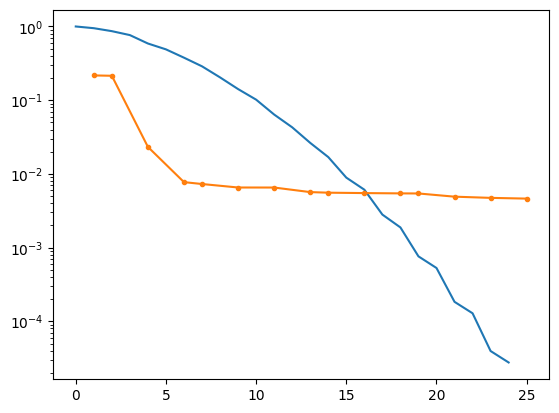

In [30]:
plt.semilogy(pod_s[:max_svs])
plt.semilogy(num_svs, err_per_sv, '.-')
plt.show()